In [1]:
# make n folders in a specific path
import os

def make_folders(path, n):
    for i in range(1, n+1):
        os.makedirs(os.path.join(path, str(i)), exist_ok=True)

make_folders('/Users/nickaloyd/Library/Mobile Documents/com~apple~CloudDocs/Purdue/Deep Learning/Car Kaggle Comp/data', 196)

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

def load_image(image_num, dataset_split = 'train'):
    _ = '../Car Kaggle Comp/car-classification-with-adversarial-defense/cars_training_image/cars_train/'
    if dataset_split == 'test': _ = '../Car Kaggle Comp/car-classification-with-adversarial-defense/cars_testing_image/car_test_with_adv_attack/'
    return cv2.imread(_ + image_num)

# training only right now
def write_image(img, class_num, image_num, dataset_split = 'train'):
    cv2.imwrite(f'../Car Kaggle Comp/data/{class_num}/{image_num}', img)


# pre processing functions
def flip(img):
    return cv2.flip(img, 1)

def add_noise(img, sigma=0.03, mean=0):
    row, col= img.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    gauss = gauss.reshape(row, col)
    noisy = img + gauss
    return noisy

def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    return result

def grayscale(img):
    img = np.array(img)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


In [3]:
import pandas as pd 

test_csv = pd.read_csv('../Car Kaggle Comp/car-classification-with-adversarial-defense/car_dataset_test_boundingBox_image_number.csv')
train_csv = pd.read_csv('../Car Kaggle Comp/car-classification-with-adversarial-defense/car_boundingBox_class_and_image_number.csv')

def get_csv(dataset_split = 'train'):
    if dataset_split == 'test': return test_csv
    return train_csv

writing images for test
0.0
0.12436264146250467
0.24872528292500934
0.373087924387514
0.4974505658500187
0.6218132073125233
0.746175848775028
0.8705384902375326
0.9949011317000374


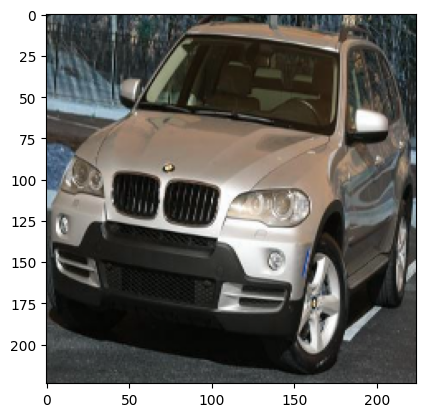

In [10]:
def write_test_image(img, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/test_data/{image_num}', img)

def write_test_images(dataset_split = 'test', resolution = (224, 224)):
    for i, row in enumerate(test_csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(test_csv))
        
        row = row[1]
        
        image_num = row['image']
        if dataset_split == 'train': class_num = row['Class']

        img = load_image(row['image'], dataset_split)

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        #img = grayscale(img)
        
        plt.imshow(img)
        write_test_image(img, image_num)

def write_train_image(img, class_num, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/data/{class_num}/{image_num}', img)

def write_train_images(dataset_split = 'train', resolution = (224, 224)):
    for i, row in enumerate(train_csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(train_csv))
        
        row = row[1]
        
        class_num = row['Class']
        image_num = row['image']

        img = load_image(row['image'], 'train')

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        img = grayscale(img)
        
        plt.imshow(img)
        write_image(img, class_num, image_num)


def write_images(dataset_split = 'train', resolution = (224, 224)):
    print(f'writing images for {dataset_split}:')
    csv = get_csv(dataset_split)

    for i, row in enumerate(csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(csv))
        
        row = row[1]

        if dataset_split == 'train': class_num = row['Class']

        image_num = row['image']

        img = load_image(row['image'], dataset_split)

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        #img = grayscale(img)
        
        plt.imshow(img)

        if dataset_split == 'test': 
            write_test_image(img, image_num)
        
        else:
            write_image(img, class_num, image_num)

    print(f'done writing images for {dataset_split}.')

#write_images('train')
#write_images('test')

In [11]:
def write_test_image(img, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/test_data/{image_num}', img)

def write_test_images(dataset_split = 'test', resolution = (224, 224)):
    for i, row in enumerate(test_csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(test_csv))
        
        row = row[1]
        
        image_num = row['image']
        if dataset_split == 'train': class_num = row['Class']

        img = load_image(row['image'], dataset_split)

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        img = grayscale(img)
        
        plt.imshow(img)
        write_test_image(img, image_num)

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model

# Residual Block
def identity_block(x, filters):
    f1, f2, f3 = filters
    x_skip = x  # Preserve the input for the skip connection

    # First convolution layer
    x = Conv2D(f1, (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = Conv2D(f2, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third convolution layer
    x = Conv2D(f3, (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    # Add skip connection
    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

# Convolutional Block (used to downsample)
def conv_block(x, filters, strides=(2, 2)):
    f1, f2, f3 = filters
    x_skip = x  # Preserve the input for the skip connection

    # First convolution layer
    x = Conv2D(f1, (1, 1), strides=strides, padding='valid')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Second convolution layer
    x = Conv2D(f2, (3, 3), strides=(1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Third convolution layer
    x = Conv2D(f3, (1, 1), strides=(1, 1), padding='valid')(x)
    x = BatchNormalization()(x)

    # Process the skip connection
    x_skip = Conv2D(f3, (1, 1), strides=strides, padding='valid')(x_skip)
    x_skip = BatchNormalization()(x_skip)

    # Add skip connection
    x = Add()([x, x_skip])
    x = Activation('relu')(x)

    return x

# Build ResNet-50 Model
def ResNet50(input_shape=(224, 224, 3), classes=10):
    inputs = Input(input_shape)

    # Initial convolution and max-pooling
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual blocks
    x = conv_block(x, [64, 64, 256], strides=(1, 1))
    x = identity_block(x, [64, 64, 256])
    x = identity_block(x, [64, 64, 256])

    x = conv_block(x, [128, 128, 512], strides=(2, 2))
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])
    x = identity_block(x, [128, 128, 512])

    x = conv_block(x, [256, 256, 1024], strides=(2, 2))
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])
    x = identity_block(x, [256, 256, 1024])

    x = conv_block(x, [512, 512, 2048], strides=(2, 2))
    x = identity_block(x, [512, 512, 2048])
    x = identity_block(x, [512, 512, 2048])

    # Final layers
    x = GlobalAveragePooling2D()(x)
    x = Dense(classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

# Instantiate and compile the model
input_shape = (224, 224, 3)  # Modify if using grayscale (e.g., (224, 224, 1))
num_classes = 196  # Set this to match the number of classes in your dataset

model = ResNet50(input_shape=input_shape, classes=num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
#model.summary()

# Now you can proceed to train the model with your dataset
# Example using ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0 / 255.0,
    validation_split=0.2
)


data_dir = '/Users/nickaloyd/Library/Mobile Documents/com~apple~CloudDocs/Purdue/Deep Learning/Car Kaggle Comp/data'

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    subset='validation'
)

# Train the model
epochs = 10
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_53 (Conv2D)  │ (None, 112, 112,  │      9,472 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_53[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_49       │ (None, 112, 112,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ activation_49[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_54 (Conv2D)  │ (None, 56, 56,    │      4,160 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_54[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_50       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_55 (Conv2D)  │ (None, 56, 56,    │     36,928 │ activation_50[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_55[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_51       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_56 (Conv2D)  │ (None, 56, 56,    │     16,640 │ activation_51[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_57 (Conv2D)  │ (None, 56, 56,    │     16,640 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_56[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │      1,024 │ conv2d_57[0][0]   │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 56, 56,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_52       │ (None, 56, 56,    │          0 │ add_16[0][0]    

 Total params: 23,989,316 (91.51 MB)

 Trainable params: 23,936,196 (91.31 MB)

 Non-trainable params: 53,120 (207.50 KB)

Found 6598 images belonging to 196 classes.
Found 1546 images belonging to 196 classes.
Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


104/104 ━━━━━━━━━━━━━━━━━━━━ 838s 8s/step - accuracy: 0.0060 - loss: 6.3025 - val_accuracy: 0.0039 - val_loss: 5.3368
Epoch 2/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 851s 8s/step - accuracy: 0.0106 - loss: 5.2658 - val_accuracy: 0.0052 - val_loss: 5.4427
Epoch 3/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 920s 9s/step - accuracy: 0.0201 - loss: 5.0844 - val_accuracy: 0.0065 - val_loss: 5.3588
Epoch 4/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 720s 7s/step - accuracy: 0.0241 - loss: 4.9622 - val_accuracy: 0.0136 - val_loss: 5.6529
Epoch 5/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 692s 7s/step - accuracy: 0.0381 - loss: 4.8188 - val_accuracy: 0.0298 - val_loss: 5.2364
Epoch 6/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 691s 7s/step - accuracy: 0.0464 - loss: 4.5822 - val_accuracy: 0.0052 - val_loss: 7.2637
Epoch 7/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 716s 7s/step - accuracy: 0.0570 - loss: 4.5466 - val_accuracy: 0.0155 - val_loss: 7.8254
Epoch 8/10
104/104 ━━━━━━━━━━━━━━━━━━━━ 699s 7s/step - accuracy: 0.0871 - loss: 4.1577 - val_accuracy: 0.062

In [22]:
import os
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

# Define a function to load, preprocess, and predict for each image
def predict_single_image(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)
    prediction = model.predict(img_array, verbose=0)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return predicted_class

# Directory of unlabeled images
unlabeled_data_dir = '../Car Kaggle Comp/test_data'
unlabeled_images = [os.path.join(unlabeled_data_dir, img) for img in os.listdir(unlabeled_data_dir)]

# Predict on each image
predicted_labels = []
for i, img_path in enumerate(unlabeled_images):
    if i % 100 == 0:
        print(f"Predicting image {i+1}/{len(unlabeled_images)} = {100*(i+1)/len(unlabeled_images):.2f}%")
    predicted_class = predict_single_image(img_path, model)
    predicted_labels.append(predicted_class)
    #print(f"Image: {img_path}, Predicted Label Index: {predicted_class}")

print(predicted_labels)

Predicting image 1/8041 = 0.01%
Predicting image 101/8041 = 1.26%
Predicting image 201/8041 = 2.50%
Predicting image 301/8041 = 3.74%
Predicting image 401/8041 = 4.99%
Predicting image 501/8041 = 6.23%
Predicting image 601/8041 = 7.47%
Predicting image 701/8041 = 8.72%
Predicting image 801/8041 = 9.96%
Predicting image 901/8041 = 11.21%
Predicting image 1001/8041 = 12.45%
Predicting image 1101/8041 = 13.69%
Predicting image 1201/8041 = 14.94%
Predicting image 1301/8041 = 16.18%
Predicting image 1401/8041 = 17.42%
Predicting image 1501/8041 = 18.67%
Predicting image 1601/8041 = 19.91%
Predicting image 1701/8041 = 21.15%
Predicting image 1801/8041 = 22.40%
Predicting image 1901/8041 = 23.64%
Predicting image 2001/8041 = 24.88%
Predicting image 2101/8041 = 26.13%
Predicting image 2201/8041 = 27.37%
Predicting image 2301/8041 = 28.62%
Predicting image 2401/8041 = 29.86%
Predicting image 2501/8041 = 31.10%
Predicting image 2601/8041 = 32.35%
Predicting image 2701/8041 = 33.59%
Predicting im

In [ ]:
'''import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader



# Define the path to your local data folder
data_dir = '../Car Kaggle Comp/data'
test_data_dir = '../Car Kaggle Comp/test_data'

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load the dataset
full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split into training and validation sets (optional)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Training set: {len(train_loader.dataset)} samples")
print(f"Validation set: {len(val_loader.dataset)} samples")'''

In [ ]:
'''# Load the dataset (the original dataset, not a subset)
#full_dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Get the number of classes
num_classes = len(full_dataset.classes)

# Create DataLoader for training set
train_loader = DataLoader(full_dataset, batch_size=64, shuffle=True)

# 2. Define the CNN Model
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 1 channel for grayscale
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Calculate the size of the feature map after conv and pooling
        self._to_linear = None
        self.convs(torch.randn(1, 1, 128, 64))  # Pass a dummy input to calculate the output size

        # Fully connected layers
        self.fc1 = nn.Linear(self._to_linear, 512)  # Adjust based on computed size
        self.fc2 = nn.Linear(512, num_classes)  # Output layer size matches the number of classes

    def convs(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Apply first conv + relu + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Apply second conv + relu + pooling
        if self._to_linear is None:
            self._to_linear = x.numel()  # Save the number of elements for the fully connected layer
        return x

    def forward(self, x):
        x = self.convs(x)  # Apply convolutional layers
        x = x.view(x.size(0), -1)  # Flatten the tensor correctly
        x = torch.relu(self.fc1(x))  # Apply first fully connected layer
        x = self.fc2(x)  # Apply second fully connected layer (output layer)
        return x

# 3. Initialize Model, Loss Function, and Optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)  # Pass num_classes to the model

criterion = nn.CrossEntropyLoss()  # Loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. Train Function
def train_model(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagate
            optimizer.step()  # Update weights

            running_loss += loss.item()

            # Compute accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Print loss and accuracy per epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# 5. Start Training
train_model(model, train_loader, criterion, optimizer, device, epochs=7)'''

In [ ]:
def write_test_image(img, image_num):
    cv2.imwrite(f'../Car Kaggle Comp/test_data/{image_num}', img)

def write_test_images(dataset_split = 'test', resolution = (224, 224)):
    for i, row in enumerate(test_csv.iterrows()):
        # show progress 
        if i % 1000 == 0: print(i/len(test_csv))
        
        row = row[1]
        
        image_num = row['image']
        if dataset_split == 'train': class_num = row['Class']

        img = load_image(row['image'], dataset_split)

        x1 = row['x1']
        y1 = row['y1']
        x2 = row['x2']
        y2 = row['y2']
        img = img[y1:y2, x1:x2]
        
        img = cv2.resize(img, resolution)
        img = grayscale(img)
        
        plt.imshow(img)
        write_test_image(img, image_num)

In [ ]:
def get_image(index, dataset_split = 'test', resolution = (224, 224)):
    row = test_csv.iloc[index]

    image_num = row['image']
    img = load_image(row['image'], dataset_split)

    x1 = row['x1']
    y1 = row['y1']
    x2 = row['x2']
    y2 = row['y2']
    img = img[y1:y2, x1:x2]

    img = cv2.resize(img, resolution)
    img = grayscale(img)

    plt.imshow(img)
    return img


# 2. Define the prediction function
def predict_image(model, image_path, device):
    # Load the image
    image = Image.open(f'../Car Kaggle Comp/test_data/{image_path}')
    plt.imshow(image)
    plt.show()
    
    # Preprocess the image
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, 1, 128, 64)
    
    # Move the image to the correct device
    image = image.to(device)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient calculation for inference
    with torch.no_grad():
        # Get the model output
        outputs = model(image)
        
        # Get the predicted class (index of the max value)
        _, predicted_class = torch.max(outputs, 1)
    
    # Return the predicted class (index)
    return predicted_class.item()

#img = get_image(3, 'test')

predicted_class = predict_image(model, '00001.jpg', device)
print(f'predicted_class: {predicted_class}')
print(f"Predicted class: {predicted_class} (Class name: {full_dataset.classes[predicted_class]})")

# show a random image from the predicted class
def show_random_image(predicted_class):
    for i, row in enumerate(train_csv.iterrows()):
        if row[1]['Class'] == predicted_class:
            plt.imshow(load_image(row[1]['image']))
            break

#show_random_image(predicted_class)
#plt.show()
class_name = full_dataset.classes[predicted_class]

show_random_image(predicted_class)

In [ ]:
import os
import torch
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# 1. Define the image preprocessing pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
    transforms.Resize((128, 64)),  # Resize image to 128x64
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale images
])

# 2. Create a custom dataset for the test data (since it's not in ImageFolder format)
class TestDataset(Dataset):
    def __init__(self, test_data_dir, transform=None):
        self.test_data_dir = test_data_dir
        self.transform = transform
        # Get list of all image filenames
        self.image_files = [f for f in os.listdir(test_data_dir) if os.path.isfile(os.path.join(test_data_dir, f))]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        image_path = os.path.join(self.test_data_dir, self.image_files[idx])
        image = Image.open(image_path)
        
        # Apply transformation (resizing, normalizing, etc.)
        if self.transform:
            image = self.transform(image)
        
        return image

# 3. Define the prediction function
def predict_image(model, image_path, device):
    # Preprocess and load the image
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
        transforms.Resize((128, 64)),  # Resize image to 128x64
        transforms.ToTensor(),  # Convert to tensor
        transforms.Normalize((0.5,), (0.5,))  # Normalize for grayscale images
    ])
    
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension (1, 1, 128, 64)
    image = image.to(device)
    
    model.eval()  # Set the model to evaluation mode
    
    # Predict
    with torch.no_grad():
        outputs = model(image)
        _, predicted_class = torch.max(outputs, 1)
    
    return predicted_class.item()

# 4. Load the test dataset and make predictions
def predict_test_data(model, test_data_dir, device):
    test_dataset = TestDataset(test_data_dir, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    
    predictions = []
    model.eval()  # Set the model to evaluation mode
    
    # Loop through the test data
    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted_classes = torch.max(outputs, 1)
            predictions.extend(predicted_classes.cpu().numpy())
    
    return predictions

# Example usage:
test_data_dir = '../Car Kaggle Comp/test_data'
predictions = predict_test_data(model, test_data_dir, device)

# Print the predicted classes for the first 5 images
print(predictions)  # You can map these predictions to class names if needed

In [ ]:
predictions = predicted_labels

# save predictions to a csv file
import pandas as pd

car_class_names = pd.read_csv('../Car Kaggle Comp/car-classification-with-adversarial-defense/car_class_and_model.csv')

# Map the predicted class indices to class names
predicted_class_names = [car_class_names.iloc[pred]['Class_name'] for pred in predictions]
print(predicted_class_names)


# for all of the predicted_class_names, write them to a csv file, with the index being the ID + 1
# (since the index starts at 0, but the ID starts at 1)
df = pd.DataFrame(predicted_class_names, columns=['Class_name'])
df.index += 1  # Start index at 1
df.index.name = 'ID'
df.to_csv('predictions.csv')


[5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 111, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5